# Traveltime tomography using the Eikonal equation (2D case)

@Author: Ettore Biondi - ebiondi@caltech.edu


First create a conda env as:

`conda create --name Eikonal python==3.9`

Then run the notebook within that environment after the installation steps below.

Activate the conda env.

Import everything you'll need.

Download eikonal2d.py into the working directory by downloading it from Drive and uploading it in colab.

https://drive.google.com/file/d/1EtTudLCntiKnq2o3BxG5F7ouwxb1pRj-/view

In [138]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np
import occamypy as o
import eikonal2d as k
import torch
from FNO import *
# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'jet_r',
    'image.aspect'   : 'auto',
    'axes.grid'      : False,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
# Velocity field
dx = dz = 0.1
nx, nz = 100, 100
x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)

filename = 'DatVel30_Sou100_Rec100_Dim100x100_Downsampled.npz'
with np.load(filename, allow_pickle=True) as fid:
    train_data = EikonalDataset(fid, 'train')
x_train_vels = train_data.vels
vel_field = x_train_vels[0].cpu().detach().numpy()


# Velocity model
vv = o.VectorNumpy(vel_field, ax_info=[o.AxInfo(nx, 0, dx, "x [km]"), o.AxInfo(nz, 0, dz, "z [km]")])
# vv[:] = 1. + 0.1*z
# for r in range(vv):
#     for c in range(len(vv[0])):
#         vv[r][c] = vel_field[r][c]

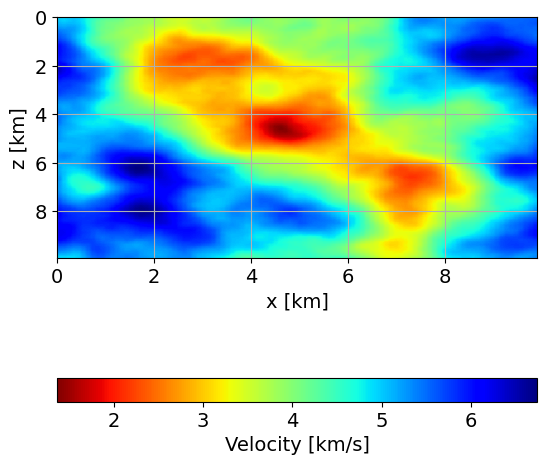

In [140]:
fig, ax = plt.subplots()
im = ax.imshow(vv.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel(vv.ax_info[0].l)
plt.ylabel(vv.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

In [176]:
# Source/Receiver positions
# SouPos = np.array([[int(nx/2), int(nx/2)]])
# RecPos = np.array([[ix,25] for ix in np.arange(0,nx)])
SouPos = np.array([[int(83.1187), int(4.5870)]])
RecPos = np.array([[int(20.4088), int(54.3552)]])

print(SouPos.shape)
print(RecPos.shape)


# Data vector
tt_data = o.VectorNumpy((SouPos.shape[0], RecPos.shape[0]))
                        # ax_info=[o.AxInfo(SouPos.shape[0], 0, 1, "rec_id"), vv.ax_info[0]])
tt_data.zero()

# Setting Forward non-linear operator
Eik2D_Op = k.EikonalTT_2D(vv, tt_data, SouPos, RecPos)
Eik2D_Op.forward(False, vv, tt_data)

(1, 2)
(1, 2)


In [178]:
# # Plotting traveltime vector
# fig, ax = plt.subplots()
# # ax.plot(tt_data.ax_info[1].plot(), tt_data[0], lw=2)
# ax.grid()
# # plt.xlabel(tt_data.ax_info[1].l)
# plt.ylabel("Traveltime [s]")
# ax.set_ylim(0, 25)
# ax.set_xlim(tt_data.ax_info[1].o, tt_data.ax_info[1].last)
# plt.tight_layout()
# plt.show()

In [179]:
# Dot-product test for the linearized Eikonal equation in 1D
Eik2D_Lin_Op = k.EikonalTT_lin_2D(vv, tt_data, SouPos, RecPos)
# Eik2D_Lin_Op.dotTest(True)

## Sensitivity kernel

Let's compute the sensitivity kernel for a given source using the linearized Eikonal operator.

REG


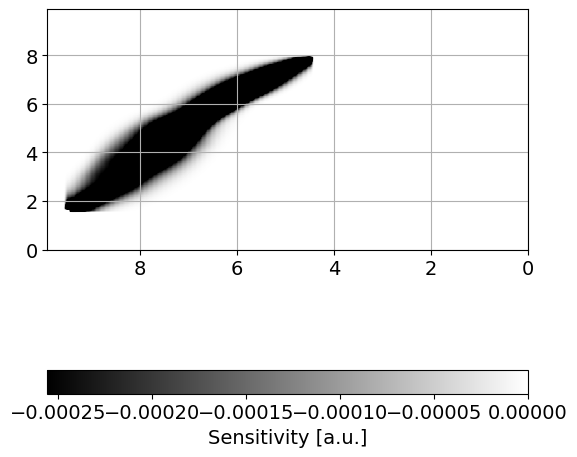

MAX AND MIN OF FMM:
0.0
-0.002558028188581157


In [182]:
tt_pert = tt_data.clone().set(1.0)
kernel1 = vv.clone()
# Computing the kernel
Eik2D_Lin_Op.adjoint(False, kernel1, tt_pert, True)
fig, ax = plt.subplots()
im = ax.imshow(kernel1.plot(), extent=[z[-1], z[0], x[0], x[-1] ], aspect=0.5, cmap=plt.get_cmap("gray"), vmin=kernel1.min()*0.1, vmax=kernel1.max())
ax = plt.gca()
ax.grid()
# plt.xlabel(kernel.ax_info[0].l)
# plt.ylabel(kernel.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Sensitivity [a.u.]')
plt.tight_layout()
plt.show()
kernel_reg = kernel1.plot().T
print("MAX AND MIN OF FMM:")
print(np.max(kernel_reg))
print(np.min(kernel_reg))

MODEL
torch.Size([1, 100, 100, 3])


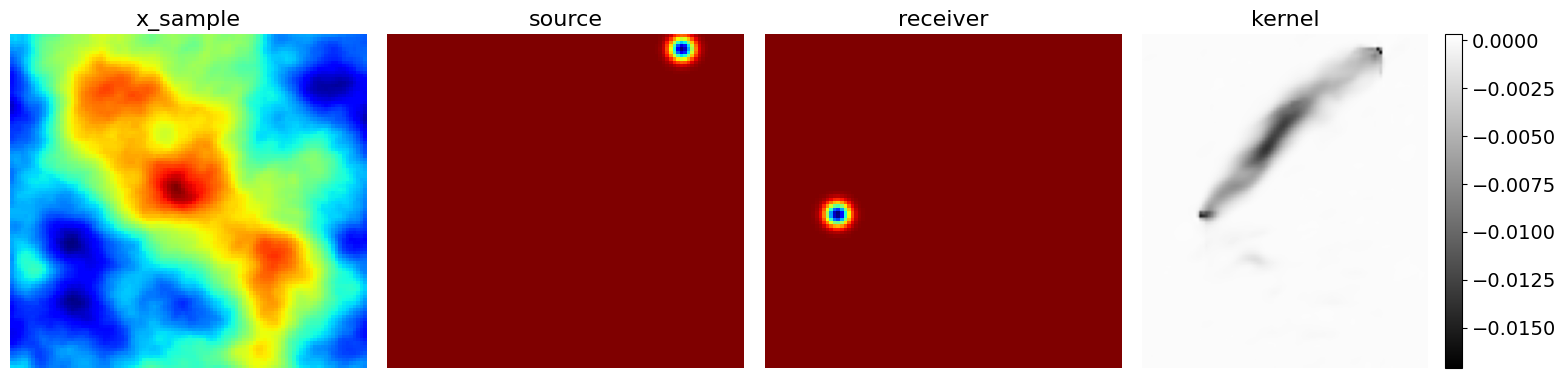

In [173]:
tt_pert = tt_data.clone().set(1.0)
kernel = vv.clone()
# Computing the kernel
Eik2D_Lin_Op.adjoint(False, kernel, tt_pert, False)

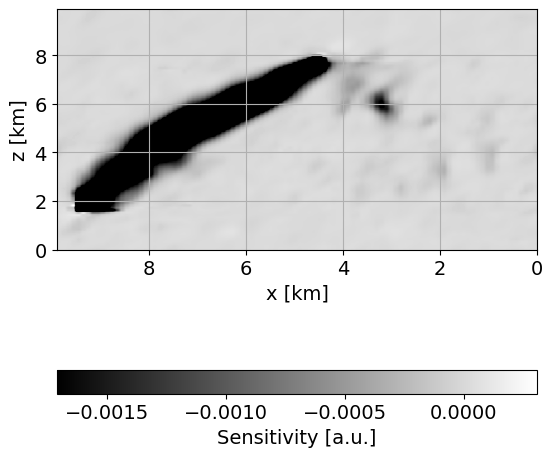

MAX AND MIN OF LABEL:
0.0003082156181335449
-0.01709754765033722


array([[ 2.75224447e-05,  2.03549862e-05,  8.91089439e-06, ...,
         2.74032354e-05,  3.07112932e-05,  3.00556421e-05],
       [ 1.96099281e-05,  1.24722719e-05,  9.35792923e-06, ...,
         3.18735838e-05,  3.02791595e-05,  2.60472298e-05],
       [ 1.30683184e-05,  1.32620335e-05,  1.47968531e-05, ...,
         2.15172768e-05,  2.00718641e-05,  1.60485506e-05],
       ...,
       [ 1.41113997e-05, -2.68220901e-06, -2.18600035e-05, ...,
         3.47197056e-05,  2.83420086e-05,  2.03996897e-05],
       [ 1.42008066e-05,  3.72529030e-06, -1.05798244e-05, ...,
         2.07275152e-05,  1.81049109e-05,  1.57654285e-05],
       [ 2.10851431e-05,  1.15782022e-05, -2.68220901e-06, ...,
         1.57058239e-05,  1.87307596e-05,  2.10404396e-05]])

In [183]:
fig, ax = plt.subplots()
im = ax.imshow(kernel.plot().T, extent=[z[-1], z[0], x[0], x[-1] ], aspect=0.5, cmap=plt.get_cmap("gray"), vmin=kernel.min()*0.1, vmax=kernel.max())
ax = plt.gca()
ax.grid()
plt.xlabel(kernel.ax_info[0].l)
plt.ylabel(kernel.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Sensitivity [a.u.]')
plt.tight_layout()
plt.show()
kernel_model = kernel.plot()
print("MAX AND MIN OF LABEL:")
print(np.max(kernel_model))
print(np.min(kernel_model))
kernel_model


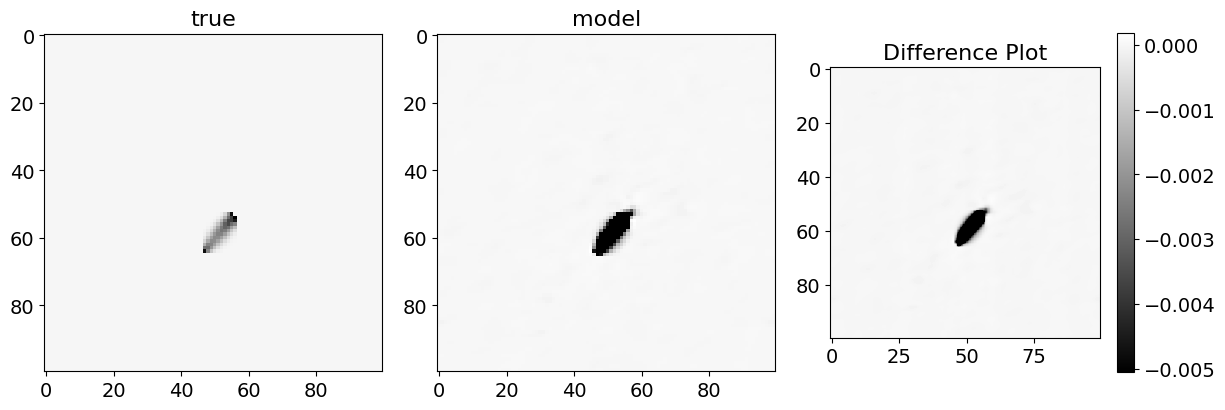

In [152]:
num_images = 3
plt.figure(figsize=(12,4))

images = [img for img in [kernel_reg, kernel_model]]

labels = ["true", "model"]

scale_min = np.min([np.min(x) for x in images])
scale_max = np.max([np.max(x) for x in images])

imgs = []

for i, (img, label) in enumerate(zip(images, labels)):
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, vmin=scale_min*0.1, vmax=scale_max, cmap='gray', aspect='equal')
    plt.title(label)
    imgs.append(img)

plt.subplot(1, num_images, 3)
plt.imshow(imgs[1] - img[0], vmin=scale_min*0.1, vmax=scale_max, cmap='gray', aspect='equal')
plt.title("Difference Plot")

plt.tight_layout()
# plt.title(f"Test, image {j}")
plt.colorbar()
plt.show()

## Inversion

In [ ]:
# Fast-Marching-Method (FMM)
# dx = dz = 0.05
dx = dz = 0.1
nx, nz = 100, 100
x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)

# Background Velocity model
# vv0 = o.VectorNumpy((nx,nz), ax_info=[o.AxInfo(nx, 0, dx, "x [km]"), o.AxInfo(nz, 0, dz, "z [km]")])
# vv0[:] = 1.0 + z*0.1
vv0 = o.VectorNumpy(vel_field, ax_info=[o.AxInfo(nx, 0, dx, "x [km]"), o.AxInfo(nz, 0, dz, "z [km]")])


# Gaussian anomaly
zz, xx = np.meshgrid(z, x)
dst = np.sqrt(xx*xx+zz*zz)
sigma = 1.0
xloc = 50*dx
zloc = 50*dz
gauss = np.exp(-( ((xx-xloc)**2 + (zz-zloc)**2) / (2.0*sigma**2)))
# Constructing true model
vv = vv0.clone()
vv[:] += gauss*3

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(vv0.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel(vv0.ax_info[0].l)
plt.ylabel(vv0.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(vv.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel(vv.ax_info[0].l)
plt.ylabel(vv.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

In [ ]:
# Source/Receiver positions
SouPos = np.array([[ix,nz-1] for ix in np.arange(0,nx,20)])
RecPos = np.array([[ix,0] for ix in np.arange(0,nx)])

# Data vector
tt_data = o.VectorNumpy((SouPos.shape[0], RecPos.shape[0]),
                        ax_info=[o.AxInfo(SouPos.shape[0], 0, 1, "rec_id"), vv.ax_info[0]])

# Instantiating non-linear operator
Eik2D_Op = k.EikonalTT_2D(vv, tt_data, SouPos, RecPos)
Eik2D_Lin_Op = k.EikonalTT_lin_2D(vv, tt_data, SouPos, RecPos, tt_maps=Eik2D_Op.tt_maps)
Eik2D_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op, Eik2D_Lin_Op.set_vel)

In [ ]:
# Creating observed data
Eik2D_Op.forward(False, vv, tt_data)
tt_data_obs = tt_data.clone()

In [ ]:
# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(10,5))
for ids in range(SouPos.shape[0]):
    ax.plot(tt_data.ax_info[1].plot(), tt_data[ids], lw=2)
ax.grid()
plt.xlabel(tt_data.ax_info[1].l)
plt.ylabel("Traveltime [s]")
# ax.set_ylim(5.0, 15.0)
ax.set_xlim(tt_data.ax_info[1].o, tt_data.ax_info[1].last)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# instantiate solver
BFGSBsolver = o.LBFGS(o.BasicStopper(niter=10, tolg_proj=1e-32), m_steps=30)

# Creating problem object using Smoothing filter
G = o.GaussianFilter(vv0, 1.5)

Eik2D_Inv_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op * G, Eik2D_Lin_Op.set_vel)

L2_tt_prob = o.NonlinearLeastSquares(vv0.clone(), tt_data_obs, Eik2D_Inv_NlOp,
                                     minBound=vv0.clone().set(1.),  # min velocity: 1 km/s
                                     maxBound=vv0.clone().set(2.5)) # max velocity: 2.5 km/s

In [ ]:
BFGSBsolver.run(L2_tt_prob, verbose=True)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(L2_tt_prob.model.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel(L2_tt_prob.model.ax_info[0].l)
plt.ylabel(L2_tt_prob.model.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal", label='Velocity [km/s]',
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0))
plt.tight_layout()
plt.show()